In [1]:
import pandas as pd
import numpy as np
import datetime
from itertools import product
import datetime


import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
# loading the data

# people data
ppl = pd.read_csv('C:/Users/栗寻/Desktop/RPI/6560 Intro to ML/project/predicting-red-hat-business-value/people.csv')
# activities data
act_train = pd.read_csv('C:/Users/栗寻/Desktop/RPI/6560 Intro to ML/project/predicting-red-hat-business-value/act_train.csv')
act_test = pd.read_csv('C:/Users/栗寻/Desktop/RPI/6560 Intro to ML/project/predicting-red-hat-business-value/act_test.csv')

In [3]:
# len(act_test)

## EDA

In [4]:
# combine training set and testing set of activities data for data cleaning

act = pd.concat([act_train, act_test], axis=0)

In [5]:
# histogram

# act.hist(figsize = [20,20]) 
# plt.show() 

In [6]:
# ppl.hist(figsize = [20,20])
# plt.show()

## Initial processing

In [7]:
# rename the date varibles in people dataset and activities dataset to avoid repeating feature names
# convert the date varibles to datetime type

act = act.rename(columns={'date': 'adate'})
act['adate'] = pd.to_datetime(act['adate'])

ppl = ppl.rename(columns={'date': 'pdate'})
ppl['pdate'] = pd.to_datetime(ppl['pdate'])

### cleaning: ppl dataset

In [8]:
# find missing values
# ppl.isna().sum()

In [9]:
# ppl['group_1'].unique()
# len(ppl['group_1'].unique()) # the "group_1" variable in ppl dataset has 34224 different values

In [10]:
# remap variable "group_1"

groups_unique = ppl.group_1.unique()  # catch the array with a variable

g_remap = []  # use a list to catch replacement
for g in groups_unique:
    g_remap.append([g, int(g[6:])]) 

df_g_remap = pd.DataFrame(g_remap)
df_g_remap.columns = ['group_1', '_group_1']

ppl = pd.merge(ppl, df_g_remap, on='group_1', how='left')

ppl.drop('group_1', axis=1, inplace=True)  # drop the original group_1 variable
ppl.rename(columns={'_group_1':'group_1'}, inplace=True)  # rename the new group 1 variable

In [11]:
# remap the values of variables 'char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9' in ppl dataset
# into integers starting from 0 and rename the variables to distinguish from that of act dataset

var_names = ['char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9']
for name in var_names:        
    key_unique = ppl[name].unique()

    k_remap = []
    for val in key_unique:
        k_remap.append([val, int(val[5:]) - 1])
        
    df_k_remap = pd.DataFrame(k_remap)
    df_k_remap.columns = ['{0}'.format(name), '_{0}'.format(name)]     
    
    ppl = pd.merge(ppl, df_k_remap, on=name, how='left')
    

In [12]:
# drop original columns in ppl dataset

for name in var_names:
    try:
        ppl.drop(name, axis=1, inplace=True)
    except:
        None
        
    ppl.rename(columns={'_{0}'.format(name): '{0}'.format(name)}, inplace=True)

In [13]:
# rename feature in ppl dataset to avoid repeating names

for key in ppl.keys():
    if 'char' in key:
        ppl.rename(columns={'{0}'.format(key): 'p{0}'.format(key)}, inplace=True)

In [14]:
# renaming result check
# ppl.keys()

In [15]:
# check data types to make sure that I did cleaning correctly
# ppl.dtypes

### cleaning: act dataset

In [16]:
# find missing values
# act.isna().sum()

In [17]:
# replace the values of the feature "activity_category" with the integer

rename_dic = {'type 1':1, 'type 2':2, 'type 3':3, 'type 4':4, 'type 5':5, 'type 6':6, 'type 7':7}  # using dictionary to map replacement
act['activity_category'] = act['activity_category'].replace(rename_dic)

In [18]:
# remap the values of variables 'char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9' in ppl dataset
# into integers starting from 0 and rename the variables to distinguish from that of act dataset

keyset_typed = ['char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10']
for key in keyset_typed:        
    act[key].fillna('type 0', inplace=True)   # NA values replaced by 0
    key_unique = act[key].unique()

    k_remap = []
    for k in key_unique:
        k_remap.append([k, int(k[5:])])
        
    df_k_remap = pd.DataFrame(k_remap)
    df_k_remap.columns = ['{0}'.format(key), '_{0}'.format(key)]     
    
    act = pd.merge(act, df_k_remap, on=key, how='left')


In [19]:
# drop original columns in act dataset and rename feature in act dataset to avoid repeating names

for key in keyset_typed:
    act.drop(key, axis=1, inplace=True)
        
    act.rename(columns={'_{0}'.format(key): 'a{0}'.format(key)}, inplace=True)

In [20]:
# act.keys()

In [21]:
# check data types to make sure that I did cleaning correctly
# act.dtypes

### merge two datasets into one base on peopel_id

In [22]:
# ppl.people_id.unique()
# len(ppl.people_id.unique()) # 189118 different values in people_id

In [23]:
# replace values in people id in ppl set with integer

pid_unique = ppl.people_id.unique()

pid_remap = []
for pid in pid_unique:
    try:
        pid_remap.append([pid, int(pid[4:])])
    except:
        pid_remap.append([pid, int(float(pid[4:]))])

df_p_remap = pd.DataFrame(pid_remap)
df_p_remap.columns = ['people_id', '_people_id']

In [24]:
# merge new id into ppl set, drop the original id col and rename the new column

ppl = pd.merge(ppl, df_p_remap, on='people_id')
ppl.drop('people_id', axis=1, inplace=True)
ppl.rename(columns={'_people_id':'people_id'}, inplace=True)

In [25]:
# merge new id into act set, drop the original id col and rename the new column

act = pd.merge(act, df_p_remap, on='people_id')
act.drop('people_id', axis=1, inplace=True)
act.rename(columns={'_people_id':'people_id'}, inplace=True)

In [26]:
# merge two datasets
complete = pd.merge(act, ppl, on='people_id', how='left')

In [27]:
# features extracted from date, generate 
complete['ayear'] = complete['adate'].apply(lambda x: x.date().year)
complete['amonth'] = complete['adate'].apply(lambda x: x.date().month)
complete['aday'] = complete['adate'].apply(lambda x: x.date().day)

In [28]:
complete = complete.drop(columns = ['adate'])

In [29]:
complete = complete.drop(columns = ['pdate'])

In [30]:
complete = complete.drop(columns = ['activity_id'])

In [31]:
# complete.head()

In [32]:
# complete.keys()

### separating training and testing activities set

In [33]:
# reseparate test and train data
df_train = complete[(complete['outcome'].notnull())]
df_test = complete[(complete['outcome'].isnull())]
df_test = df_test.drop(columns = ['outcome'])

In [34]:
# dict(df_train.dtypes)

In [35]:
# print(len(df_train))
# print(len(df_test))  # 498687, correctly separated

In [36]:
# the act-test dataset is not useful for generating metrics and my machine is not able to encode more than 1000000 lines of data
# hence draw 10000 lines of data from df_train

In [37]:
reducted_train = df_train[0:10000]

In [38]:
# print(len(reducted_train))

In [39]:
df_train_X = reducted_train.drop(columns = ['outcome'])
df_train_y = reducted_train['outcome']

### one-hot encoding

In [40]:
categorical_var = ['group_1', 'activity_category', 'pchar_1', 'pchar_2', 'pchar_3', 'pchar_4', 'pchar_5', 'pchar_6', 'pchar_7', 'pchar_8', 'pchar_9', 'achar_1', 'achar_2', 'achar_3', 'achar_4', 'achar_5', 'achar_6', 'achar_7','achar_8', 'achar_9', 'achar_10', 'ayear', 'amonth', 'aday']

In [41]:
df_train_dummies = pd.get_dummies(df_train_X, columns = categorical_var)

## Modeling

### splitting training and testing data for validation

In [42]:

X_train, X_test, y_train, y_test = train_test_split(df_train_dummies, df_train_y, test_size = 0.3, random_state = 38)

### Logistics Regression

In [43]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [44]:
# cross validation
print(cross_val_score(log_reg, X_train, y_train, cv=3))

[0.81705227 0.75096442 0.76682383]


In [45]:
log_pred = log_reg.predict(X_test)

*evaluation*

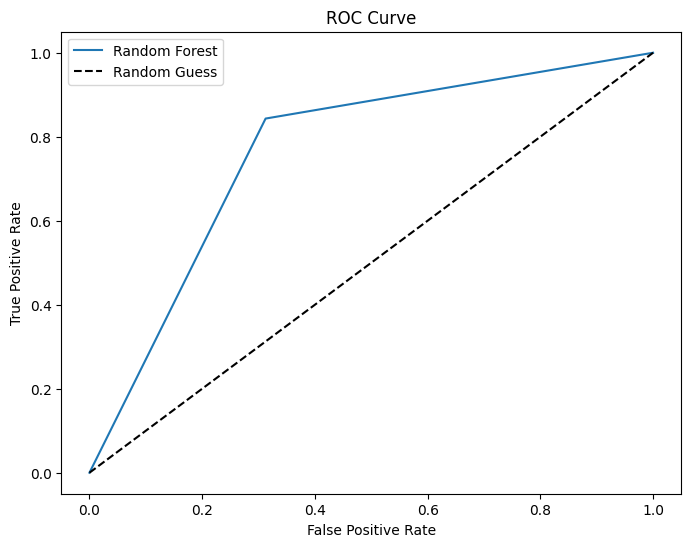

ROC AUC Score: 0.7653660220994476


In [46]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, log_pred)
print("ROC AUC Score:", roc_auc)

In [47]:
# Calculate accuracy score on the test set
accuracy = accuracy_score(y_test, log_pred)

print("Accuracy Score on Test Set:", accuracy)
print('Precision: %.3f' % precision_score(y_test, log_pred))
print('Recall: %.3f' % recall_score(y_test, log_pred))
print('F1 Score: %.3f' % f1_score(y_test, log_pred))

Accuracy Score on Test Set: 0.7626666666666667
Precision: 0.716
Recall: 0.843
F1 Score: 0.774


### XGBoosting model

In [49]:
# Initialize XGBoost Classifier
xgb_1 = xgb.XGBClassifier(max_depth = 3, n_estimators = 70)
print(np.mean(cross_val_score(xgb_1, X_train, y_train, cv=3)))

0.9481435896155076


In [50]:
# Initialize XGBoost Classifier
xgb_2 = xgb.XGBClassifier(max_depth = 5, n_estimators = 70)
print(np.mean(cross_val_score(xgb_2, X_train, y_train, cv=3)))

0.9712849785249037


In [51]:
# Initialize XGBoost Classifier
xgb_3 = xgb.XGBClassifier(max_depth = 5, n_estimators = 50)
print(np.mean(cross_val_score(xgb_1, X_train, y_train, cv=3)))

0.9481435896155076


In [ ]:
# # Define the hyperparameter grid for tuning
# param_grid = {
#     'max_depth': [3, 5],
#     'n_estimators': [50, 70]
# }

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# 2hrs...can't run this for the life of it 

In [ ]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

In [52]:
# Fit XGBoost model with best parameters on the entire training set
best_xgb_model = xgb.XGBClassifier(max_depth = 5, n_estimators = 70)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

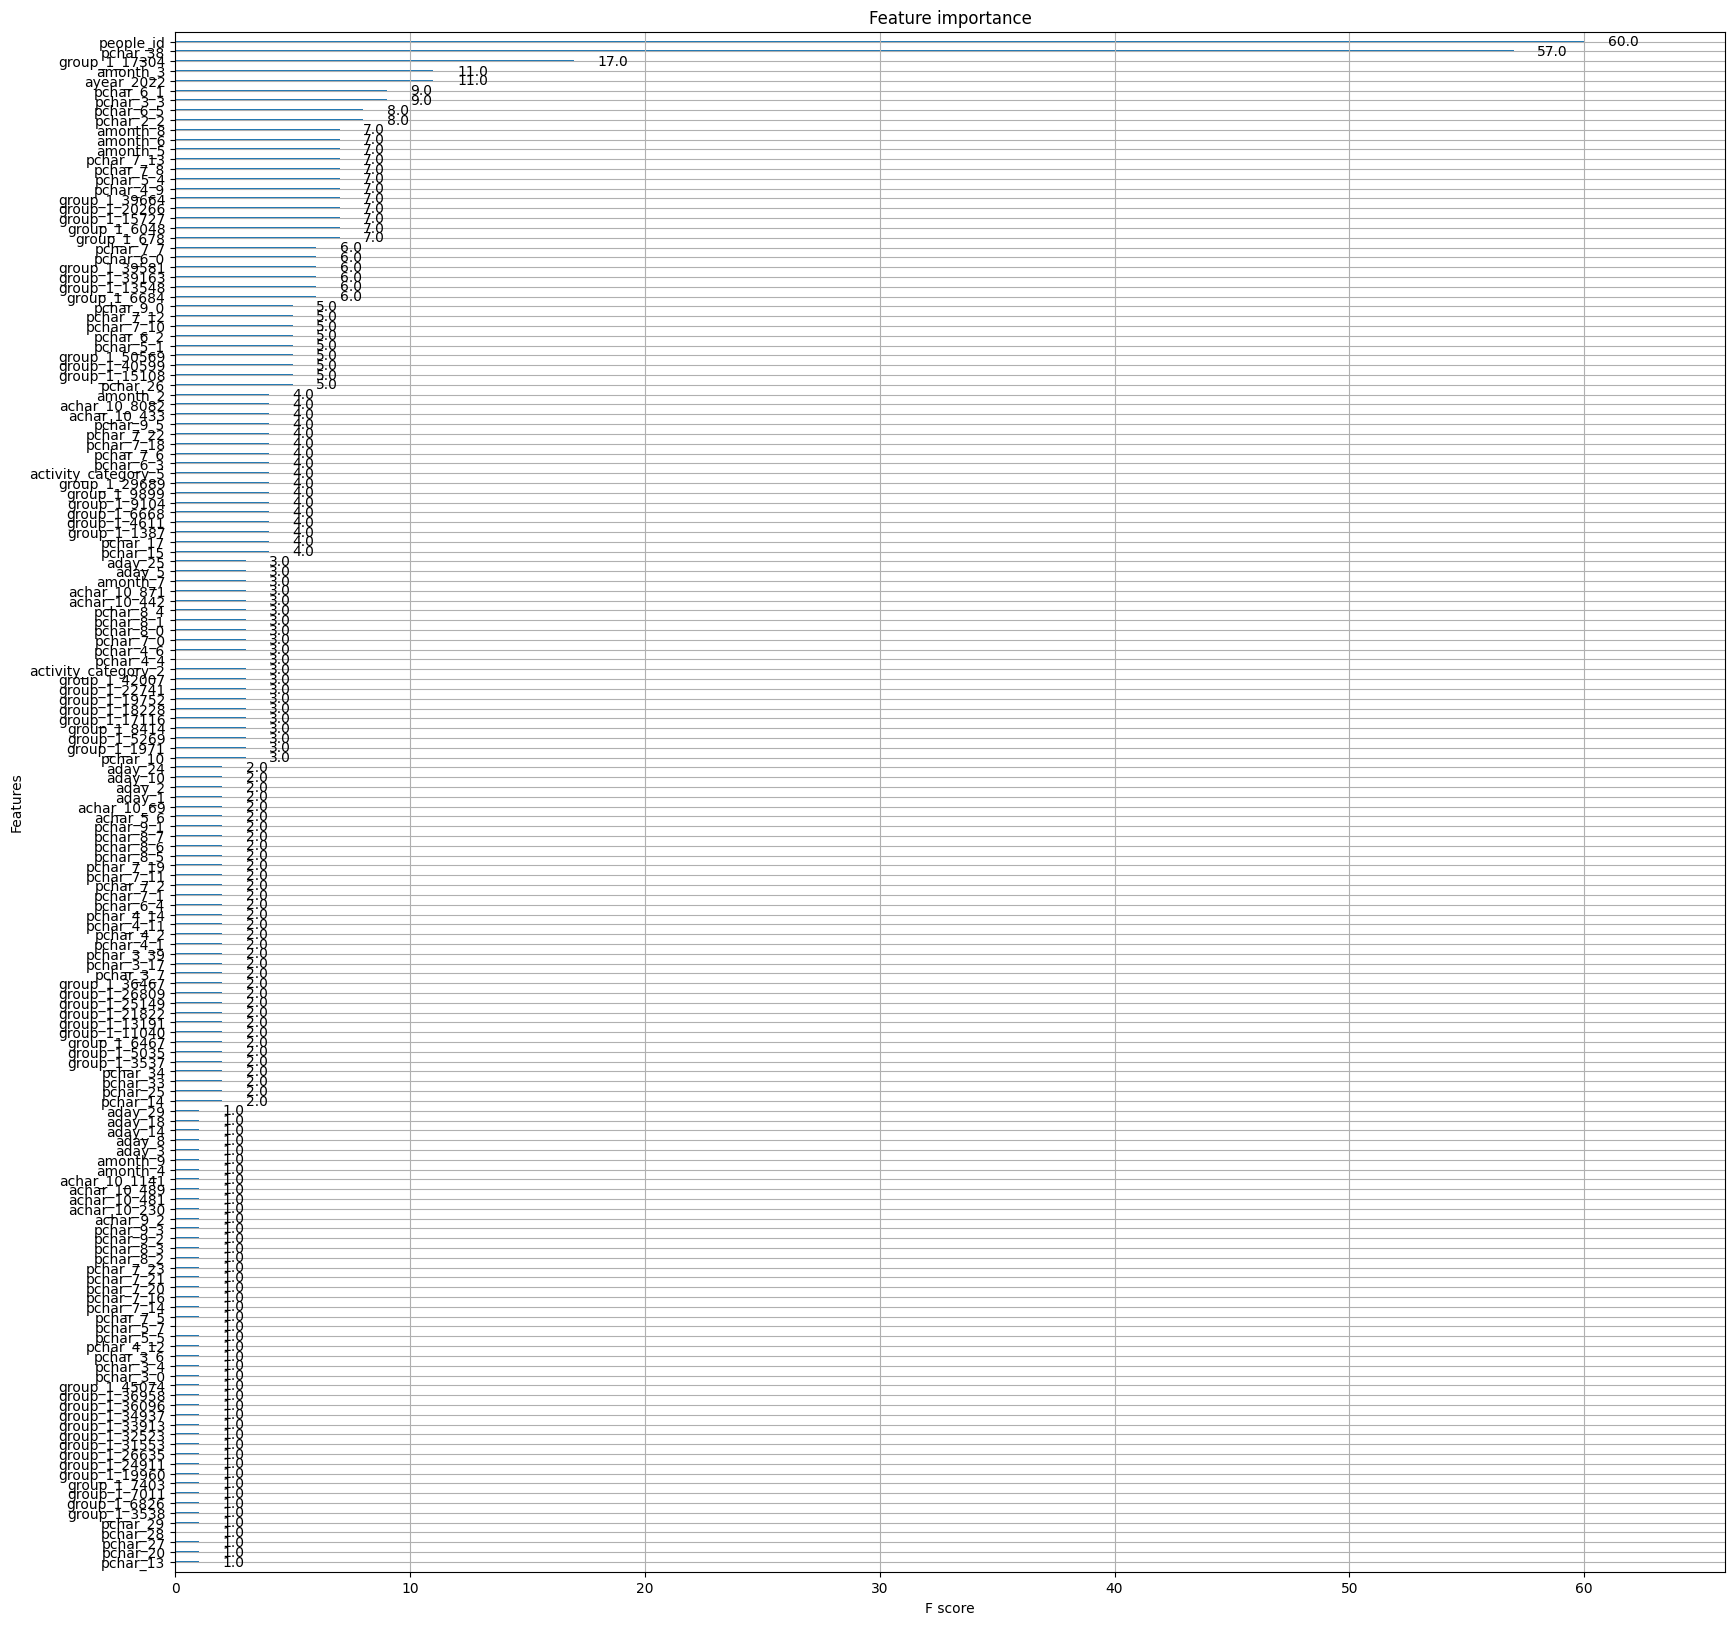

In [60]:
# Feature Importance
ax = plot_importance(best_xgb_model)
fig = ax.figure
fig.set_size_inches(20, 20)
plt.show()

In [54]:
# Make predictions on the test set
xgb_pred = best_xgb_model.predict(X_test)

*evaluation*

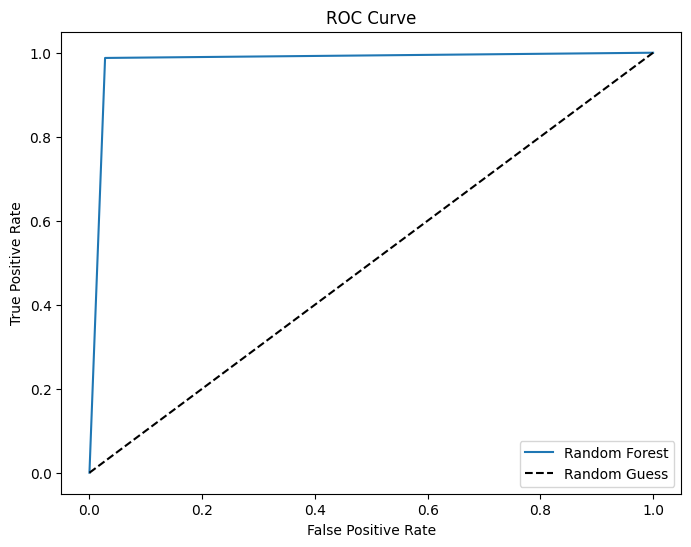

ROC AUC Score: 0.9799314376032351


In [56]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, xgb_pred)
print("ROC AUC Score:", roc_auc)

In [57]:
# Calculate accuracy score on the test set
accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy Score on Test Set:", accuracy)
print('Precision: %.3f' % precision_score(y_test, xgb_pred))
print('Recall: %.3f' % recall_score(y_test, xgb_pred))
print('F1 Score: %.3f' % f1_score(y_test, xgb_pred))

Accuracy Score on Test Set: 0.9796666666666667
Precision: 0.971
Recall: 0.988
F1 Score: 0.979


### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
# split train test sets
X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_train_y, test_size = 0.3, random_state = 7)

In [63]:
X_train.dtypes

activity_category    int64
achar_1              int64
achar_2              int64
achar_3              int64
achar_4              int64
achar_5              int64
achar_6              int64
achar_7              int64
achar_8              int64
achar_9              int64
achar_10             int64
people_id            int64
pchar_10              bool
pchar_11              bool
pchar_12              bool
pchar_13              bool
pchar_14              bool
pchar_15              bool
pchar_16              bool
pchar_17              bool
pchar_18              bool
pchar_19              bool
pchar_20              bool
pchar_21              bool
pchar_22              bool
pchar_23              bool
pchar_24              bool
pchar_25              bool
pchar_26              bool
pchar_27              bool
pchar_28              bool
pchar_29              bool
pchar_30              bool
pchar_31              bool
pchar_32              bool
pchar_33              bool
pchar_34              bool
p

In [64]:
rf_1 = RandomForestClassifier(n_estimators = 50, max_depth = 6)
print(np.mean(cross_val_score(rf_1, X_train, y_train, cv=3)))

0.9180001598955316


In [65]:
rf_2 = RandomForestClassifier(n_estimators = 70, max_depth = 4)
print(np.mean(cross_val_score(rf_2, X_train, y_train, cv=3)))

0.8574285860154095


In [66]:
rf_3 = RandomForestClassifier(n_estimators = 60, max_depth = 5)
print(np.mean(cross_val_score(rf_3, X_train, y_train, cv=3)))

0.8929996487440427


In [ ]:
# # parameters we consider
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 70, num = 10)]
# max_depth = [3, 4, 5]


In [ ]:
# # create a grid
# param_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth}

In [ ]:
# # initialize model
# rf = RandomForestClassifier()

In [ ]:
# # tune the model
# rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=2)
# rf_Grid.fit(X_train, y_train)

In [ ]:
# # print best parameter
# rf_Grid.best_params_


In [67]:
rf_b = RandomForestClassifier().fit(X_train, y_train)

In [74]:
print(rf_b)

RandomForestClassifier()


In [68]:
rf_pred = rf_b.predict(X_test)

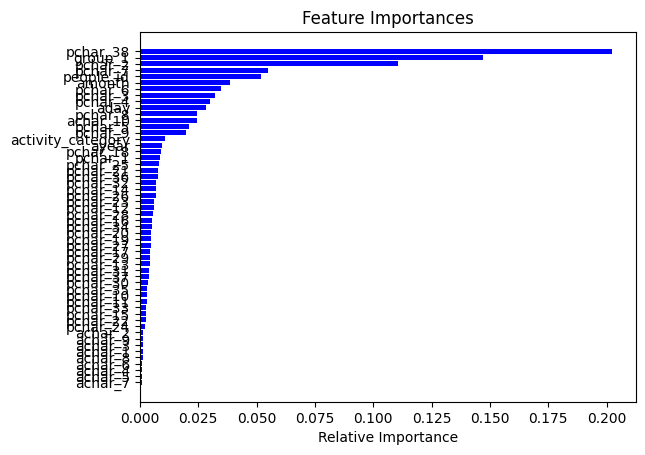

In [75]:
features = df_train_X.columns
importances = rf_b.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


plt.show()

*evaluation*

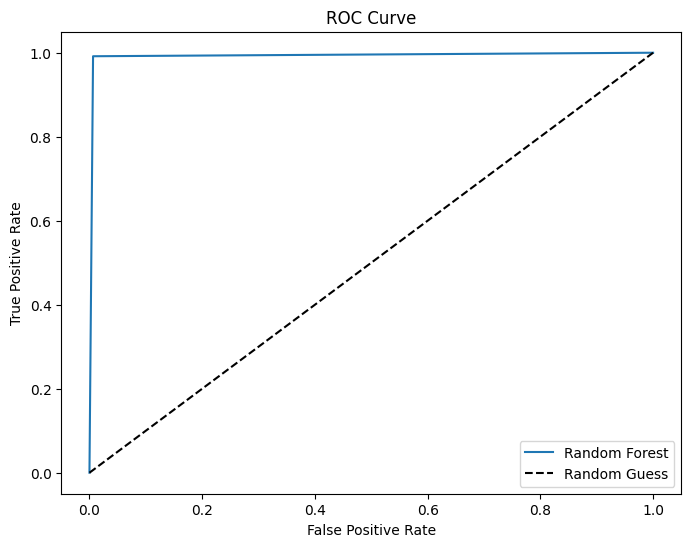

ROC AUC Score: 0.9926221692968772


In [70]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_pred)
print("ROC AUC Score:", roc_auc)

In [72]:
# Feature Importance
feature_importance = rf_b.feature_importances_
print("Feature Importance:", feature_importance)

Feature Importance: [0.01061894 0.00118868 0.00143178 0.00120449 0.00098649 0.00095886
 0.00104303 0.0008153  0.00113836 0.0012327  0.02439293 0.05207801
 0.00306571 0.00302738 0.00589126 0.00425258 0.00698234 0.00265111
 0.00530346 0.00445836 0.00894847 0.00461585 0.00490496 0.00798936
 0.00252444 0.00597858 0.00239848 0.00829562 0.00678044 0.00460139
 0.00556971 0.00437978 0.00355598 0.0041024  0.00709321 0.00274932
 0.00502522 0.00326747 0.00787359 0.00391706 0.20239693 0.14682192
 0.00869715 0.11061453 0.03205333 0.03011324 0.021141   0.03495175
 0.05479914 0.02461381 0.01986772 0.00962104 0.03846218 0.02855316]


In [73]:
# Calculate accuracy score on the test set
accuracy = accuracy_score(y_test, rf_pred)

print("Accuracy Score on Test Set:", accuracy)
print('Precision: %.3f' % precision_score(y_test, rf_pred))
print('Recall: %.3f' % recall_score(y_test, rf_pred))
print('F1 Score: %.3f' % f1_score(y_test, rf_pred))

Accuracy Score on Test Set: 0.9926666666666667
Precision: 0.993
Recall: 0.992
F1 Score: 0.992


## Summary